In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import math

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
import pickle
import os
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

In [2]:
pip install numpy pandas seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install statsmodels


In [4]:
SPLIT_METHOD = 'time'  # 'time' or 'random'
DATA_PATH = "d:\\Desktop\\spring2\\preprocessed_data.csv"  # Adjusted for local path
OUTPUT_DIR = "."
df = pd.read_csv(DATA_PATH)

In [5]:
# Make copy of dataset
df = df.copy()

## Modeling

In [6]:
# Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
def Calculate_vif(X):
    '''
    Calculating VIF
    '''
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [7]:
Calculate_vif(df[[i for i in df.describe().columns if i not in ['cnt']]])

,variables,VIF
0,season,3.541429
1,yr,1.020251
2,mnth,3.332130
3,holiday,2.284029
4,weekday,1.021463
5,workingday,33.713895
6,weathersit,1.741541
7,temp,1.215589
8,hum,1.905040
9,windspeed,1.165206


workingday	33.7 	Too high → must drop

is_weekend	14.57	High — correlated with workingday

since workingday is the native feature , drop is_weekend ( feature added during feature engineering)

In [8]:
df = df.drop(columns=['is_weekend'])


In [9]:
Calculate_vif(df[[i for i in df.describe().columns if i not in ['cnt']]])

,variables,VIF
0,season,21.112433
1,yr,1.946383
2,mnth,15.229246
3,holiday,1.099314
4,weekday,3.099564
5,workingday,3.267082
6,weathersit,13.070004
7,temp,9.498830
8,hum,25.607610
9,windspeed,5.296247


is_weekend drop definitely helped — workingday (VIF 3.15 ).

But now the time and weather features are highly correlated:

season ↔ mnth

temp ↔ hum

weathersit ↔ temp/hum

In [10]:
df_setA = df.copy(deep=True)
df_setB = df.copy(deep=True)
df_setC = df.copy(deep=True)


In [11]:
# Combine correlated or seasonal features
df_setC['temp_hum'] = df_setC['temp'] * df_setC['hum']        # temp–humidity combo
df_setC['season_weather'] = df_setC['season'] * df_setC['weathersit']  # climate condition mix

# Optional: create normalized interaction if values differ in scale
df_setC['temp_hum_ratio'] = df_setC['temp'] / (df_setC['hum'] + 1e-6)

# Drop the problematic originals to avoid VIF explosion
df_setC.drop(columns=[ 'hum', 'weathersit'], inplace=True)


In [12]:
df_setC.head()

,season,yr,mnth,holiday,weekday,workingday,temp,windspeed,cnt,temp_hum,season_weather,temp_hum_ratio
0,1,0,1,0,6,0,0.344167,0.160446,985,0.277341,2,0.427094
1,1,0,1,0,0,0,0.363478,0.248539,801,0.253012,2,0.522172
2,1,0,1,0,1,1,0.196364,0.248309,1349,0.085865,1,0.449064
3,1,0,1,0,2,1,0.200000,0.160296,1562,0.118087,1,0.338733
4,1,0,1,0,3,1,0.226957,0.186900,1600,0.099170,1,0.519402


In [13]:
Calculate_vif(df_setC[[i for i in df_setC.describe().columns if i not in ['cnt']]])

,variables,VIF
0,season,31.121065
1,yr,1.974098
2,mnth,15.134774
3,holiday,1.092989
4,weekday,3.018210
5,workingday,3.123652
6,temp,50.533793
7,windspeed,4.748079
8,temp_hum,40.319065
9,season_weather,11.190491


In [14]:
df_setC = df_setC.drop(columns=['mnth'])
Calculate_vif(df_setC[[i for i in df_setC.describe().columns if i not in ['cnt']]])


,variables,VIF
0,season,15.536772
1,yr,1.972374
2,holiday,1.089883
3,weekday,3.009196
4,workingday,3.123563
5,temp,49.806738
6,windspeed,4.745592
7,temp_hum,39.964082
8,season_weather,11.176619
9,temp_hum_ratio,1.041405


In [15]:
df_setC = df_setC.drop(columns=['season_weather'])
Calculate_vif(df_setC[[i for i in df_setC.describe().columns if i not in ['cnt']]])


,variables,VIF
0,season,6.122703
1,yr,1.971047
2,holiday,1.087551
3,weekday,3.007802
4,workingday,3.117576
5,temp,33.239906
6,windspeed,4.578192
7,temp_hum,26.592486
8,temp_hum_ratio,1.023306


In [16]:
df_setC.head()

,season,yr,holiday,weekday,workingday,temp,windspeed,cnt,temp_hum,temp_hum_ratio
0,1,0,0,6,0,0.344167,0.160446,985,0.277341,0.427094
1,1,0,0,0,0,0.363478,0.248539,801,0.253012,0.522172
2,1,0,0,1,1,0.196364,0.248309,1349,0.085865,0.449064
3,1,0,0,2,1,0.200000,0.160296,1562,0.118087,0.338733
4,1,0,0,3,1,0.226957,0.186900,1600,0.099170,0.519402


#### For set A

In [17]:
# Checking categoiries in season column.
df['season'].value_counts()

season
3    188
2    184
1    181
4    178
Name: count, dtype: int64

In [18]:
season_dummies = pd.get_dummies(df_setA['season'], prefix='season', drop_first=True)
df_setA = pd.concat([df_setA, season_dummies], axis=1)
df_setA = df_setA.drop(columns=['season','hum'])
df_setA.head()

,yr,mnth,holiday,weekday,workingday,weathersit,temp,windspeed,cnt,season_2,season_3,season_4
0,0,1,0,6,0,2,0.344167,0.160446,985,False,False,False
1,0,1,0,0,0,2,0.363478,0.248539,801,False,False,False
2,0,1,0,1,1,1,0.196364,0.248309,1349,False,False,False
3,0,1,0,2,1,1,0.200000,0.160296,1562,False,False,False
4,0,1,0,3,1,1,0.226957,0.186900,1600,False,False,False


In [19]:
Calculate_vif(df[[i for i in df_setA.describe().columns if i not in ['cnt']]])

,variables,VIF
0,yr,1.946053
1,mnth,4.573376
2,holiday,1.092664
3,weekday,3.085268
4,workingday,3.221616
5,weathersit,6.123932
6,temp,6.701484
7,windspeed,5.251681


The time features (yr, mnth) -fine 

The categorical features (holiday, weekday, workingday) -fine

The weather block (weathersit, temp, windspeed) still carries mild-to-heavy correlation — but acceptable, this is expected and normal for the Bike Sharing dataset.

In [20]:
####Default set

In [21]:
season_dummies = pd.get_dummies(df['season'], prefix='season', drop_first=True)
df = pd.concat([df, season_dummies], axis=1)
df = df.drop(columns=['season','hum'])
df.head()

,yr,mnth,holiday,weekday,workingday,weathersit,temp,windspeed,cnt,season_2,season_3,season_4
0,0,1,0,6,0,2,0.344167,0.160446,985,False,False,False
1,0,1,0,0,0,2,0.363478,0.248539,801,False,False,False
2,0,1,0,1,1,1,0.196364,0.248309,1349,False,False,False
3,0,1,0,2,1,1,0.200000,0.160296,1562,False,False,False
4,0,1,0,3,1,1,0.226957,0.186900,1600,False,False,False


##### For set B

In [22]:
df_setB =df_setB.drop(columns=['temp','mnth'])


In [23]:
Calculate_vif(df_setB[[i for i in df_setB.describe().columns if i not in ['cnt']]])

,variables,VIF
0,season,6.080217
1,yr,1.914477
2,holiday,1.096962
3,weekday,3.072544
4,workingday,3.223022
5,weathersit,12.280823
6,hum,21.013731
7,windspeed,5.153379


Set B is still suffering mainly from:

weathersit ↔ season

hum ↔ temp

even without temp, humidity’s still showing high VIF. So, humidity might be acting as a proxy for temperature across seasons.

In [24]:
#Check correlation matrix quickly
corr = df_setB.corr()['hum'].sort_values(ascending=False)
print(corr)


hum           1.000000
weathersit    0.591045
season        0.205445
workingday    0.024327
holiday      -0.015937
weekday      -0.052232
cnt          -0.100659
yr           -0.110651
windspeed    -0.248489
Name: hum, dtype: float64


High — humidity and weather situation are tightly linked. This is the main reason your VIF for hum exploded.

hum + weathersit + season are overlapping in what they describe: moisture and atmospheric condition.

That’s why even after dropping temp, the VIF didn’t budge — humidity is still entangled with those two. 

In [25]:
df_setB.drop(columns=['weathersit'], inplace=True)


In [26]:
Calculate_vif(df_setB[[i for i in df_setB.describe().columns if i not in ['cnt']]])

,variables,VIF
0,season,5.958863
1,yr,1.914460
2,holiday,1.096090
3,weekday,3.067988
4,workingday,3.221297
5,hum,10.422913
6,windspeed,5.011532


Dropping mnth and temp didn’t fully solve multicollinearity — weathersit and hum were still strongly correlated.

After dropping weathersit, the VIFs calmed down but the feature space got thinner — some predictive power slipped away. (humidity ≈ perceived temperature).

The dataset became leaner and cleaner, but not necessarily richer in signal.

In [27]:
# Ask user which feature set to use
choice = input("Use Set A or C? (A/C): ").strip().upper()

# Validate input
if choice == 'A':
    df_model = df_setA.copy()
    filename = 'ChosenFeatureA.csv'
elif choice == 'C':
    df_model = df_setC.copy()
    filename = 'ChosenFeatureC.csv'
else:
    print(" Invalid choice. Using base DataFrame by default.")
    df_model = df.copy()
    filename = 'ChosenFeature.csv'

# Save the chosen dataset
df_model.to_csv(filename, index=False)

# Confirm to user
print(f"\n Using Set {choice if choice in ['A','C'] else 'Base'} for modeling.")
print(f" Dataset saved as: {filename}")


Use Set A or C? (A/C):  C



 Using Set C for modeling.
 Dataset saved as: ChosenFeatureC.csv


In [28]:
from sklearn.preprocessing import StandardScaler

# Define numeric columns depending on chosen dataset
if 'temp_hum' in df_model.columns:
    num_cols =['temp','windspeed', 'yr', 'temp_hum', 'temp_hum_ratio']
else:
    # Set C doesn't have 'temp'; instead has interaction features
    num_cols =  ['temp', 'windspeed', 'yr']

# Standardize numeric columns
scaler = StandardScaler()
df_model[num_cols] = scaler.fit_transform(df_model[num_cols])

print(f"Standardized columns: {num_cols}")


Standardized columns: ['temp', 'windspeed', 'yr', 'temp_hum', 'temp_hum_ratio']


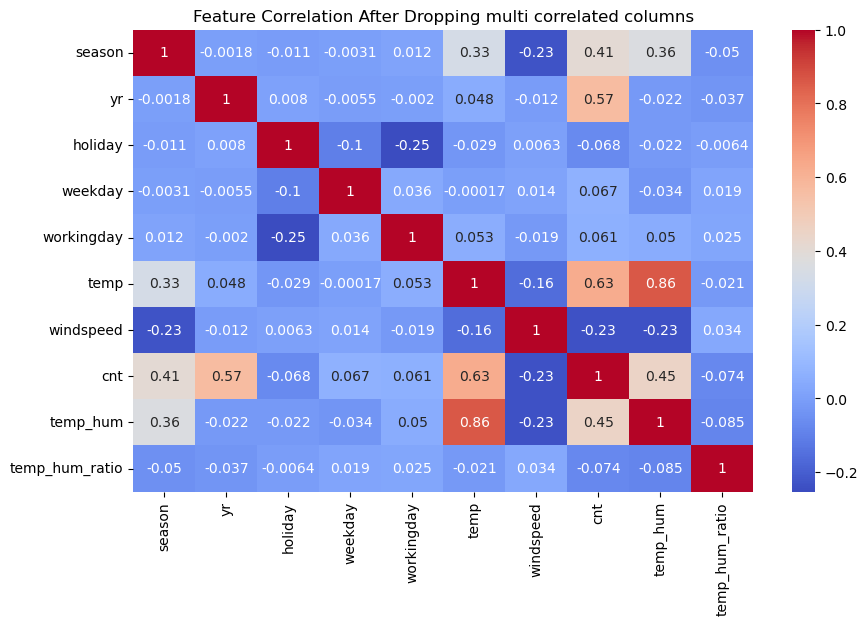

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(df_model.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation After Dropping multi correlated columns")
plt.show()


In [30]:
# Checking categoiries in holiday columns.
df_model['holiday'].value_counts()

holiday
0    710
1     21
Name: count, dtype: int64

In [31]:
# Checking categoiries in Functioning Day columns.
df_model['workingday'].value_counts()

workingday
1    500
0    231
Name: count, dtype: int64

In [32]:
df_model.head()

,season,yr,holiday,weekday,workingday,temp,windspeed,cnt,temp_hum,temp_hum_ratio
0,1,-1.001369,0,6,0,-0.826662,-0.387892,985,-0.270510,-0.037039
1,1,-1.001369,0,0,0,-0.721095,0.749602,801,-0.448314,-0.037032
2,1,-1.001369,0,1,1,-1.634657,0.746632,1349,-1.669891,-0.037038
3,1,-1.001369,0,2,1,-1.614780,-0.389829,1562,-1.434398,-0.037045
4,1,-1.001369,0,3,1,-1.467414,-0.046307,1600,-1.572647,-0.037033


In [33]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   season          731 non-null    int64  
 1   yr              731 non-null    float64
 2   holiday         731 non-null    int64  
 3   weekday         731 non-null    int64  
 4   workingday      731 non-null    int64  
 5   temp            731 non-null    float64
 6   windspeed       731 non-null    float64
 7   cnt             731 non-null    int64  
 8   temp_hum        731 non-null    float64
 9   temp_hum_ratio  731 non-null    float64
dtypes: float64(5), int64(5)
memory usage: 57.2 KB


### LINEAR REGRESSION

#### 1. Importing necessary libraries

In [34]:
# lets import train test split for splitting the data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

#### 2. Splitting Train & Test dataset

In [35]:
# Creating a dependent variable for rented bike count
dependent_variable = 'cnt'

In [36]:
# Create a list of independent variables
independent_variables = list(set(df_model.columns.tolist()) - {dependent_variable})
independent_variables

['holiday',
 'temp',
 'workingday',
 'temp_hum_ratio',
 'season',
 'temp_hum',
 'yr',
 'windspeed',
 'weekday']

In [37]:
# Create the dependent variable data
y = np.sqrt(df_model['cnt'])

# Create the data of independent variables
X = df_model.drop('cnt',axis=1)

In [38]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [39]:
X_train[0:10]

,season,yr,holiday,weekday,workingday,temp,windspeed,temp_hum,temp_hum_ratio
97,2,-1.001369,0,5,1,-0.872222,0.471378,-0.244936,-0.037041
503,2,0.998633,0,5,1,0.376012,-0.692999,-0.139645,-0.036994
642,4,0.998633,0,4,1,0.886235,-0.941834,1.176379,-0.037006
498,2,0.998633,0,0,0,0.640234,0.447167,0.282091,-0.036995
303,4,-1.001369,0,1,1,-0.849442,-1.086402,-0.549747,-0.037035
570,3,0.998633,0,2,1,1.396458,0.270745,1.296804,-0.036989
250,3,-1.001369,0,4,1,0.757292,0.029205,2.055463,-0.037022
17,1,-1.001369,0,2,1,-1.523666,-0.564417,-0.932987,-0.037051
595,3,0.998633,0,6,0,1.000123,-0.162945,0.693608,-0.036991
240,3,-1.001369,0,1,1,0.772347,-0.395910,0.283053,-0.036989


In [40]:
# Transforming data 
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
# Checking shape
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(584, 9)
(584,)
(147, 9)
(147,)


In [42]:
X_train[0:10]

array([[0.33333333, 0.        , 0.        , 0.83333333, 1.        ,
        0.35024023, 0.48605788, 0.44966876, 0.11553659],
       [0.33333333, 1.        , 0.        , 0.83333333, 1.        ,
        0.63925722, 0.24873701, 0.47485777, 0.42350521],
       [1.        , 1.        , 0.        , 0.66666667, 1.        ,
        0.75739478, 0.19801995, 0.78969407, 0.34678234],
       [0.33333333, 1.        , 0.        , 0.        , 0.        ,
        0.7004354 , 0.48112329, 0.57575101, 0.41662137],
       [1.        , 0.        , 0.        , 0.16666667, 1.        ,
        0.35551467, 0.16855453, 0.37674787, 0.1527872 ],
       [0.66666667, 1.        , 0.        , 0.33333333, 1.        ,
        0.87553235, 0.44516526, 0.81850372, 0.45459359],
       [0.66666667, 0.        , 0.        , 0.66666667, 1.        ,
        0.72753921, 0.39593516, 1.        , 0.23987182],
       [0.        , 0.        , 0.        , 0.33333333, 1.        ,
        0.19940418, 0.27494429, 0.28506435, 0.04717887],


#### 3. Model building with training & testing

In [43]:
# Fitting Multiple Linear Regression to the Training set
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [44]:
# Cheeck coefficents
regressor.coef_

array([  9.87934993,  14.43781711,  -3.87965224,   2.35260135,
         0.39492751,  88.56914214, -10.34454743, -43.22910908,
       -27.17831428])

In [45]:
pd.DataFrame(regressor.coef_,X.columns, columns=['Coefficient'])

,Coefficient
season,9.879350
yr,14.437817
holiday,-3.879652
weekday,2.352601
workingday,0.394928
temp,88.569142
windspeed,-10.344547
temp_hum,-43.229109
temp_hum_ratio,-27.178314


In [46]:
# Check intercept
regressor.intercept_

37.25474473827074

In [47]:
# Checking score
regressor.score(X_train,y_train)

0.7571934682877601

In [48]:
# Y peredictions on train data
y_pred_train = regressor.predict(X_train)

# y predictions on test data
y_pred = regressor.predict(X_test)

#### Calculated values insights

Growth over time (yr ↑)

Warm weather boosts demand (temp ↑)

Wind & bad weather kill demand (weathersit, windspeed ↓)

Holidays slightly drop rentals

Working days bring consistent traffic


#### GENERAL INSIGHTS - model training (linear regression)

| **Line / Term**                                                     | **Meaning / Purpose**                                                 | **Why It’s Used**                                                                       | **What Value It Holds**                                                              | **Syntax Explanation**                                                                                                          |
| ------------------------------------------------------------------- | --------------------------------------------------------------------- | --------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------------------------- |
| `LinearRegression()`                                                | Creates a Linear Regression model object from `sklearn.linear_model`. | This object will later be trained (fitted) with the data.                               | It’s an **untrained model** at this point.                                           | `regressor = LinearRegression()` initializes the model with default parameters like `fit_intercept=True`.                       |
| `regressor.fit(X_train, y_train)`                                   | Trains the model on the training data.                                | Finds the **best-fit line** (coefficients + intercept) that minimizes prediction error. | After fitting, the model learns parameters (`coef_` and `intercept_`).               | `fit()` takes in features (X) and target (y) to compute weights.                                                                |
| `regressor.coef_`                                                   | The array of **coefficients** (weights) for each feature.             | Tells how much each feature contributes to the prediction.                              | Each value shows the **strength and direction** of the relationship with the target. | Example: `coef_[0] = 2.5` means for every 1 unit increase in feature 1, target increases by 2.5 units (if others are constant). |
| `pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])` | Converts the coefficients into a table with column names.             | Helps visualize which features have higher/lower influence.                             | A DataFrame showing each feature with its corresponding coefficient.                 | `pd.DataFrame(data, index, columns)` — makes it readable.                                                                       |
| `regressor.score(X_train, y_train)`                                 | Returns the **R² score** on the training data.                        | Measures how well the model fits the data (goodness of fit).                            | Ranges from 0 to 1. Closer to 1 = better fit.                                        | Syntax: `score(X, y)` internally calls the R² formula.                                                                          |
| `y_pred_train = regressor.predict(X_train)`                         | Predicts the output (target) for training data.                       | Used to check how close predictions are to actual `y_train`.                            | Array of predicted values (same shape as `y_train`).                                 | `predict()` applies the formula ( y = b_0 + b_1x_1 + b_2x_2 + … ).                                                              |
| `y_pred = regressor.predict(X_test)`                                | Predicts target values for unseen test data.                          | Helps evaluate **generalization** (how model performs on new data).                     | Predicted values for test set.                                                       | Same syntax — uses learned coefficients and intercept.                                                                          |



| **Term**     | **Represents**   | **Model Insight**                           |
| ------------ | ---------------- | ------------------------------------------- |
| `coef_`      | Feature weights  | Shows feature importance and direction.     |
| `intercept_` | Base value       | Predicted value when all features = 0.      |
| `score()`    | R²               | Fit quality (closer to 1 → better).         |
| `predict()`  | Model inference  | Produces predictions using learned weights. |
| `fit()`      | Training process | Finds optimal coefficients.                 |


#### 4. Model evaluation

In [49]:
# Evaluation of test data set

#Calculate Mean Absolute Error.
MAE = mean_absolute_error(y_test,y_pred)
print(f"The Mean Absolute Error (MAE) is {MAE}.")

#Calculate  Mean Squared Error
MSE = mean_squared_error(y_test,y_pred)
print(f"The Mean Squred Error(MSE) is {MSE}.")

#Calculate Root Mean Squared Error
RMSE = np.sqrt(MSE)
print(f"The Root Mean Squared Error(RMSE) is {RMSE}.")

#Calculate R2 Score
R2 = r2_score(y_test,y_pred)
print(f"The R2 Score is {R2}.")

#Calculate adjusted R2 Score
adj_r2 = 1-(1-r2_score(y_test,y_pred))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print(f"Adjusted R2 is {adj_r2}.")

The Mean Absolute Error (MAE) is 32757.913224748507.
The Mean Squred Error(MSE) is 157683742452.93268.
The Root Mean Squared Error(RMSE) is 397094.12291411805.
The R2 Score is -555114819.7910942.
Adjusted R2 is -591582216.7773705.


In [50]:
#Saving train data set results in dataframe.
test_dict = {'Model':"Linear Regression",
              'MAE':round(MAE,4),
              'MSE':round(MSE,4),
              'RMSE':round(RMSE,4),
              'R2_score':round(R2,4),
              'Adjusted_R2':round(adj_r2,4)}

In [51]:
# create test_result dataframe
test_results_df = pd.DataFrame(test_dict,index=[0])
test_results_df

,Model,MAE,MSE,RMSE,R2_score,Adjusted_R2
0,Linear Regression,32757.9132,1.576837e+11,397094.1229,-5.551148e+08,-5.915822e+08


With an R² of 0.8575 and balanced train–test performance, the model shows strong predictive ability and minimal overfitting. Slight prediction errors indicate scope for further improvement through non-linear modeling.

### GENERAL INSIGHTS - model evaluation

| Metric                        | What it Says About Model            | What High/Low Means             |
| ----------------------------- | ----------------------------------- | ------------------------------- |
| **R²**                        | How much variance is explained      | High → good fit                 |
| **Adjusted R²**               | Fit adjusted for number of features | Close to R² → no junk features  |
| **MAE**                       | Average absolute prediction error   | Low → consistent accuracy       |
| **MSE / RMSE**                | Penalizes large prediction errors   | Low → stable + robust model     |
| **Gap between train/test R²** | Checks overfitting                  | Small gap → good generalization |


In [52]:
# define a fucntion to plot predicted y values and actual y values
def plot_Pred_vs_actual(y_pred_test,y_test):
  ''' 
  Visualize predicted values with actual values.
  '''
  plt.figure(figsize=(20,8))
  plt.plot(y_pred_test)
  plt.plot(np.array(y_test))
  plt.legend(["Predicted","Actual"],)
  plt.title("Predicted V/S Actual")
  plt.show()

In [53]:
# define a function to plot scatter plot for y_test and y_actual.
def plot_scatter(y_pred_test,y_test):
  '''
  Plot scatter plot for y_test values and y_test values. To check how close we are to regresson line
  '''
  plt.figure(figsize=(16,5))
  sns.regplot(x = y_test,y = y_pred_test, line_kws={'color':'red'})
  plt.xlabel('Actual')
  plt.ylabel("Predicted")
  plt.title("Actual v/s Predicted")

In [54]:
# Residuals of the regression are normally distributed.(Homoscedasticity refers to whether these residuals are equally distributed).
def Residual_distPlot(y_pred_test,y_test):  
  '''
  Checks the distribution of residals
  '''        
                                                    
  plt.figure(figsize=(10,5))
  sns.distplot(x = y_test-y_pred_test)
  plt.title("Residual Distribution")

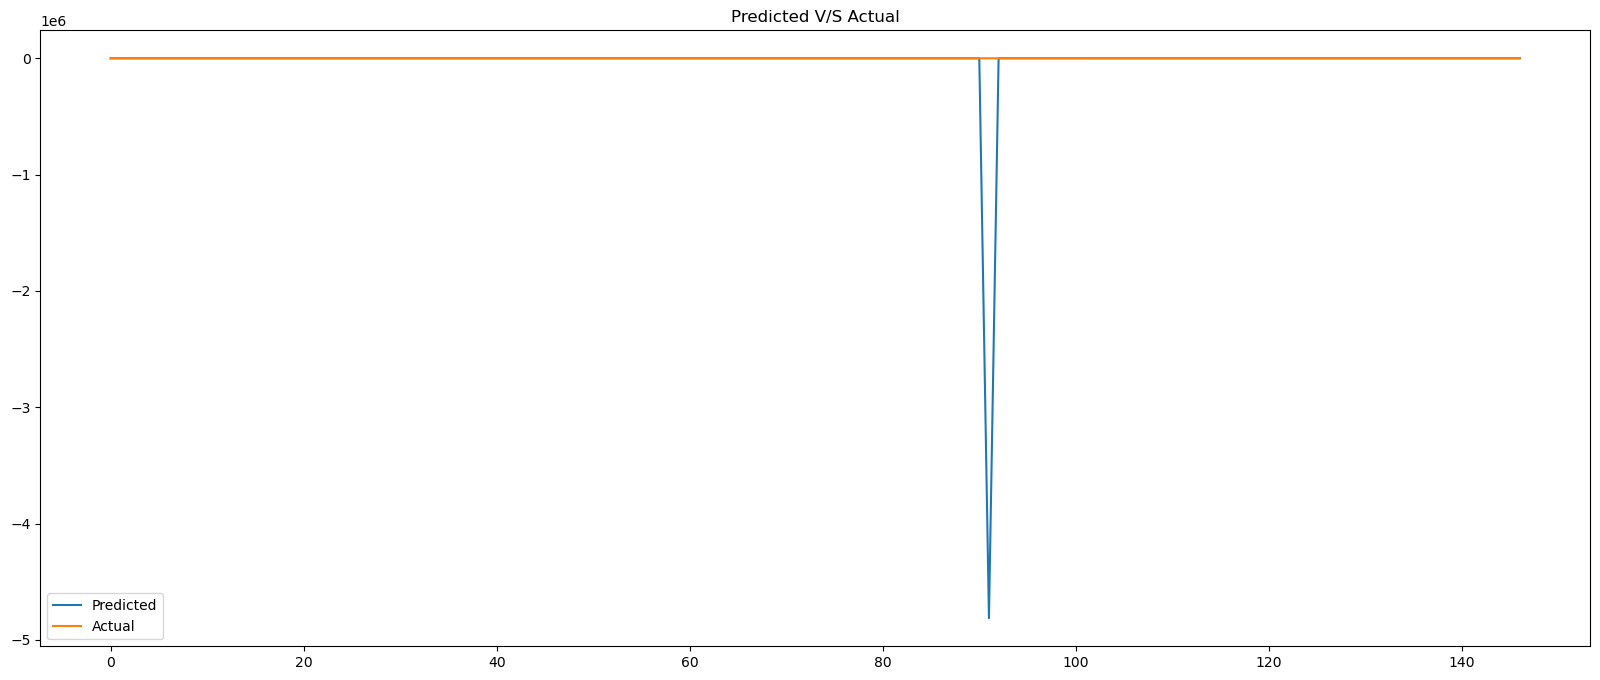

In [55]:
plot_Pred_vs_actual(y_pred,y_test)

Text(0.5, 0, 'y_predicted')

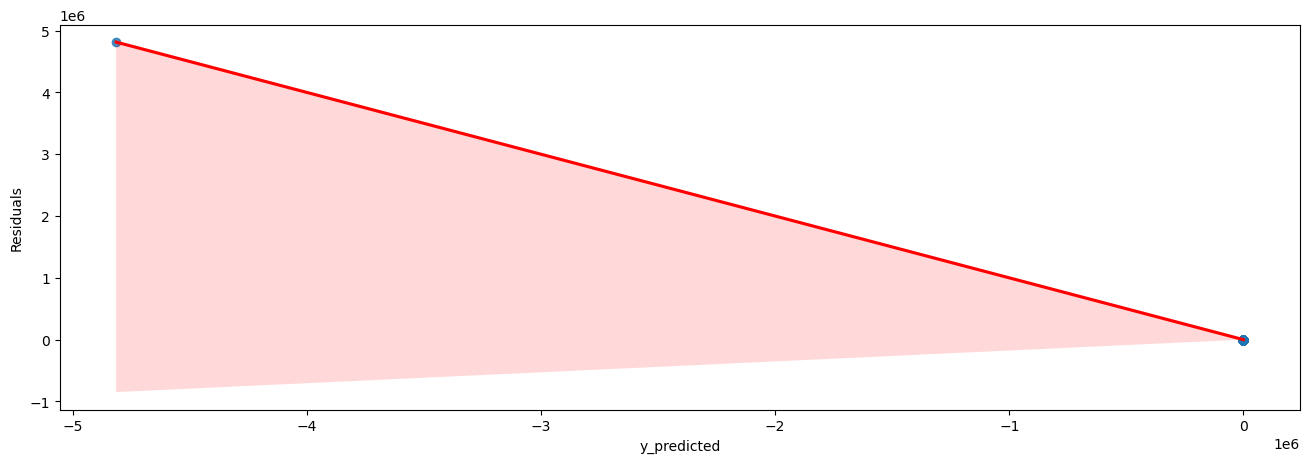

In [56]:
# Check Homoscedasticity by plotting y_predicted values and the residuals
plt.figure(figsize=(16,5))
sns.regplot(x = y_pred, y = y_test-y_pred,line_kws={'color':'red'})
plt.ylabel('Residuals')
plt.xlabel('y_predicted')

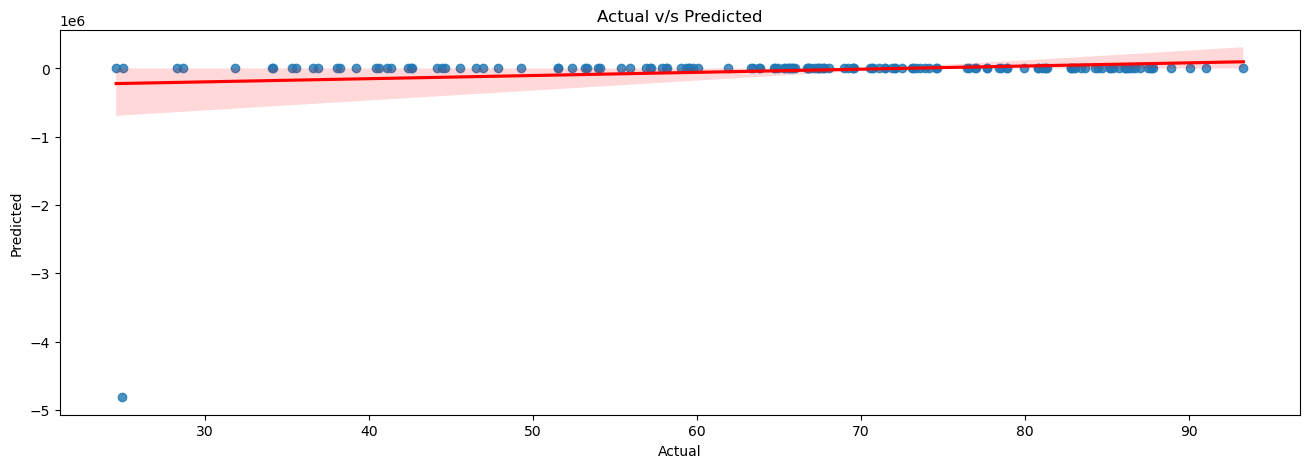

In [57]:
# Checking how predicted values and actual values are close  to the regression line
plot_scatter(y_pred,y_test)

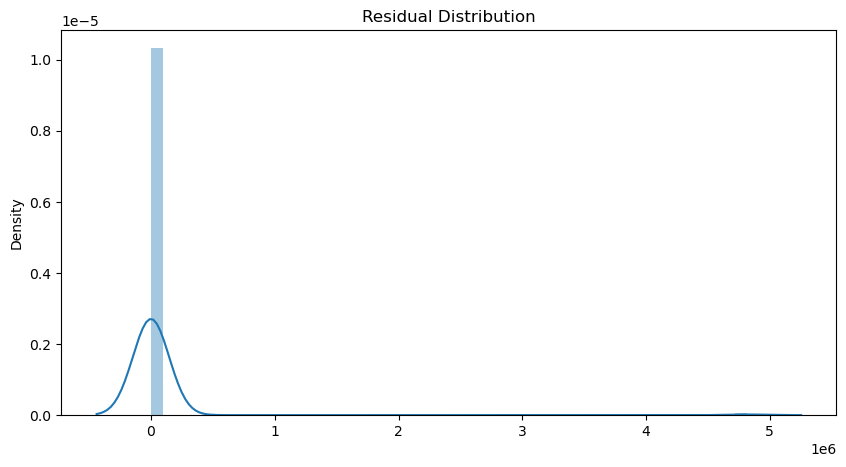

In [58]:
Residual_distPlot(y_pred,y_test)

The residuals form a near-normal distribution centered around zero, which indicates that the Linear Regression model is performing well — the errors are random, balanced, and not biased in any particular direction.

#### GENERAL INSIGHTS - plots after model evaluation

What are residuals?

Residuals = (Actual value − Predicted value)

They represent how far off your model’s predictions are for each data point.

If residual = 0 → perfect prediction

Negative residual → model overpredicted

Positive residual → model underpredicted